In [1]:
import geopandas as gpd
import pandas as pd
import math
import json
from sqlalchemy import create_engine

# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


In [11]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from plotting import show_soc, my_cmap

### DEFINE CONSTANTS ###
# power for charing car
POWER_charge = 11  # kw
# power during driving
POWER_driving = 10  # kw
# power during energy delivery
POWER_dicharge = 11  # kw
# average trip distance during 1h reservation
average_distance = 50  # km
# revenue per driven km
revenue_km = 0.7  # CHF
# revenue per booked h
revenue_h = 2.0  # CHF
# penalty costs (service should be reliable, otherwise customers get lost and change transport mode)
cancellation_penalty = 100  # CHF
# delta t, time step size
DT = 0.25  # h
# episode length of one day
EPISODE_LEN = int(24 / DT)
# EPISODE_LEN = 12 # --> only used for test dataset

# TODO: model some electicity price curve that (randomly) changes over the day
electricity_price = np.ones(EPISODE_LEN)


class CarsharingEnv(gym.Env):
    def __init__(self, stations, nr_vehicles=5, dt=DT):
        """
        Parameters
        ----------
        nr_vehicles : int, optional
            Number of deployed vehicles, by default 5
        dt : float, optional
            Time step size, by default 0.25 (a quarter hour)
        """
        
        ######### todo #########
        ######### add vehicle info #########
        self.vehicles_id = []
        self.nr_vehicles = None
        self.dt = dt
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_discharging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list = []
        # TODO: load reservation data

        # set battery capacity for each vehicle # TODO: load this from the database as well

        # --> how select battery capacity?

        self.battery_capacities = np.array([75 for _ in range(nr_vehicles)])
        self.chariging_power = np.array([11 for _ in range(nr_vehicles)]) ########### different dependent on vehicle type? ######
        # State: two parts:
        # 1) location of vehicle: station number (1000-5000), or needed charging level (0-100) if start of trip,
        # reservation number ( x'xxx'xxx) druing trip, or -1 if car not available
        # 2) SOC for each vehicle (between 0 and 1)
        self.observation_space = gym.spaces.Box(
            low=np.array([-1, 0] * nr_vehicles),  # Lower bounds for each dimension
            high=np.array([9999999, 1] * nr_vehicles)  # Upper bounds for each dimension
        )

        self.state_dim = self.observation_space.shape[0]
        # Action: discrete, but one for each vehicle --> MultiDiscrete with 3 possible actions for each of them
        # Action space: 0 = do nothing, 1 = charge, 2 = discharge
        self.action_space = spaces.MultiDiscrete([3 for _ in range(nr_vehicles)])
        # TODO (later): simulate the power grid demand for energy (energy expected from Mobility after bidding-phase)
        
        # add stations
        self.stations = stations

    def reset(self, dayly_data, vehicle_list):
        ######### todo #########
        ######## stategie for initial charging ##########
        # set time to 0
        self.t = 0
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_discharging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list = []
        # resets all vehicles to beginning of day
        self.vehicles_id = vehicle_list  #
        self.nr_vehicles = len(self.vehicles_id)  # total number of cars
        #car_SOC = np.random.rand(self.nr_vehicles) 
        #car_SOC = np.zeros(self.nr_vehicles) # random initial charging levels
        #car_SOC = np.full((self.nr_vehicles,), 0.2)
        car_SOC = np.random.uniform(low=0.5, high=1, size=self.nr_vehicles)
        
        car_locations = dayly_data.iloc[:,
                        0].values  # location of vehicle: station number (1000-5000), or needed charging level (0-100) if start of trip,
        # reservation number ( x'xxx'xxx) druing trip, or -1 if car not available

        # create inital state
        self.state = np.concatenate([car_locations, car_SOC])

        return self.state
    
    def cancel_trips_low_SOC(self, dayly_data, reservations, stations):
        print("time")
        print(self.t + 1)
        
        ############ todo: implement car assignment problem ############
        
        
        # check if car booked or not (start of booking)
        booking_start = (self.state[:self.nr_vehicles] >= 0) & (self.state[:self.nr_vehicles] <= 100)
        
        ### check if engough energy charged for booked trip (otherwise trips needs to be cancelled) ###
        
        # array with 0 for all car that do not start a new trip, otherwise 1
        bol_soc_needed = np.zeros_like(booking_start)
        bol_soc_needed[booking_start == True] = 1
        
        # check SOC needed for each car (0 for all cars that do not start a new trip)
        # car location equals to needed SOC for all cars that start a new trip
        soc_needed = self.state[:self.nr_vehicles] * bol_soc_needed
        
        # calculate difference between SOC of car at the moment and needed SOC for starting the trip
        difference_energy = self.state[self.nr_vehicles:]*  self.battery_capacities * bol_soc_needed - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars (previous timestamps SOC minus SOC needed for trip)
        self.state[self.nr_vehicles:] = (self.state[self.nr_vehicles:] *  self.battery_capacities- soc_needed * not_cancelled_trips_int) / self.battery_capacities 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        # count number of cancellation, used for reward penalty
        penalty_counter = 0
 

        ### remove booking from dataset (if reservation is cancelled, the car is again available) ###
        for index in indices:
            found = False
            last_station = 0
            t = self.t
            car_location = -1
            while not found:
                # search last station of car in bookings, replace reservation number with last location
                if t > 0:
                    car_location = dayly_data.iloc[index, t]
                    if car_location >= 1000 and car_location <= 6000:
                        found = True
                        penalty_counter += self.car_assignment(car_location, dayly_data, reservations, stations, index, soc_needed)
                else:
                    # if no station back in time, set car location to -1
                    found = True
                t = t - 1
                
            # update current state of car with actual location
            self.state[:self.nr_vehicles][index] = car_location
            
            # remove reservation from dataset
            changed = False
            #print("")
            #print("update cancelled car")
            for col_index, col_data in enumerate(dayly_data.iloc[index]):
                if col_index >= self.t + 1 and dayly_data.iloc[index, col_index] >= 1000000:
                    #print("")
                    #print(dayly_data.iloc[index,col_index])
                    dayly_data.iat[index, col_index] = car_location
                    #print(dayly_data.iloc[index,col_index])

                    changed = True
                elif  col_index >= self.t + 1 and dayly_data.iloc[index, col_index] <= 100:
                    #print("")
                    #print(dayly_data.iloc[index,col_index])
                    dayly_data.iat[index, col_index] = car_location
                    #print(dayly_data.iloc[index,col_index])
                    #print("")
                elif col_index >= self.t and dayly_data.iloc[index, col_index] < 1000000 and changed == True:
                    break
        #print("total penalty")
        #print(penalty_counter)
        return penalty_counter
    
    def car_assignment(self, station_id, dayly_data, reservations, stations, index_car, soc_needed):
        #print("Station which needs car")
        #print(station_id)
        stations_processing = stations.copy()
        
        # todo: problem at 23:45 timestamp
        

        # look for cars at the same station
        filtered_df = dayly_data.loc[dayly_data.iloc[:, self.t + 1] == station_id]
        
        if self.t + 1 == 96:
            reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservationfrom_daytime_endofday"] == self.t + 1)]
        else:
            reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservationfrom_daytime"] == self.t + 1)]
        
        if len(reservations_of_car) == 0:
            print("station id")
            print(station_id)
            print("car id")
            print(self.vehicles_id[index_car])
            print("reservation no")

            return 1
        reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
        reservation_no = reservations_of_car["reservation_no"].iloc[0]
        
        # create a spatial index for gdf2
        station = stations_processing[stations_processing["station_no"] == station_id]
        solution_found = False
        while solution_found is not True:
            # perform the nearest neighbor join using the spatial index
            joined = gpd.sjoin_nearest(station, stations_processing, distance_col = "distance_stations", max_distance = 5000)
            if len(joined) == 0:
                solution_found = True
                #print("no solution available")
                penalty = 1
                break
            alternative_station_ID = joined["station_no_right"].iloc[0]
            cars_at_found_station = self.state[:self.nr_vehicles] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            for index in indices:
                if self.t + 1 == 96:
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime_endofday"] >= self.t + 1) & (reservations["reservationfrom_daytime_endofday"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime_endofday"] <= self.t + 1)]  
                else:
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime"] >= self.t + 1) & (reservations["reservationfrom_daytime"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime"] <= self.t + 1)]  
                if len(reservations_of_found_car) == 0 and (self.state[self.nr_vehicles:][index] *  self.battery_capacities[index] - soc_needed[index_car]) >= 0:
                    #print("")
                    #print("Solution found:")
                    #print("reservations found")
                    #print(reservations_of_found_car)
                    #print("cancelled car index")
                    #print(index_car)
                    #print("found car index")
                    #print(index)
                    #print("location")
                    #print(self.state[:self.nr_vehicles][index])
                    #print("soc needed")
                    #print(soc_needed[index_car])
                    #print("soc in car")
                    #print(self.state[self.nr_vehicles:][index] *  self.battery_capacities[index])
                    #print("vehicle_id")
                    #print(self.vehicles_id[index])
                    solution_found = True
                    changed = False
                    #print("")
                    #print("update new car")
                    
                    penalty = joined["distance_stations"].iloc[0]/5000 
                    for col_index, col_data in enumerate(dayly_data.iloc[index]):
                        #max_duration = min(96, self.t + 1 + reservation_duration)
                        if col_index > self.t + 1 and col_index <= self.t + 1 + reservation_duration:
                            
                            #print("")
                            #print(dayly_data.iloc[index,col_index])
                            dayly_data.iat[index, col_index] = reservation_no
                            #print(dayly_data.iloc[index,col_index])
                    
                    
                        elif col_index == self.t + 1:
                            #print("")
                            #print(dayly_data.iloc[index,col_index])
                            dayly_data.iat[index, col_index] = soc_needed[index_car]
                            #print(dayly_data.iloc[index,col_index])
                            #print("battery before")
                            #print(self.state[self.nr_vehicles + index])
                            self.state[self.nr_vehicles+ index] = (self.state[self.nr_vehicles + index] *  self.battery_capacities[index]- soc_needed[index_car]) / self.battery_capacities[index] 
                            #print("battery after")
                            #print(self.state[self.nr_vehicles + index])
                            
                            
                        elif col_index > self.t + 1 + reservation_duration:
                            break
                    break
            if len(joined) != 0:
                stations_processing = stations_processing[stations_processing.station_no != joined["station_no_right"].iloc[0]]
                
        
                
                
            


        

        # create a spatial index for gdf2 
        
        
        #print(penalty)
        return penalty
    
    def charging(self, action, not_chargable):
        
        ############ todo: implement charging function ############
    
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
        
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
        #energy_to_charge = charging_action * POWER_charge * self.dt
       
        # can only charge until capacity is reached
        currently_charged = self.battery_capacities.tolist() * self.state[self.nr_vehicles:]
        

        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can only charge cars that are at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    def discharging(self, action, not_chargable):
        
        ############ todo: implement discharging function ############
        
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * POWER_dicharge * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.nr_vehicles:]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter):
        ############ todo ############ 
        ############ trip revenue from database ############
        ############ cancellation penalty distance weigthed (car assingment) ############
        ############ penalty for full charging or empty discharging ############
        
        # check if car on trip
        on_trip = (self.state[:self.nr_vehicles] >= 1000000) | (self.state[:self.nr_vehicles] >= 0) & (
                    self.state[:self.nr_vehicles] <= 100)
        
        
        ### compute reward ###
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t % EPISODE_LEN])
        
        # calculate discharging revenue
        rew_discharging = -np.sum(1 * energy_to_discharge * electricity_price[self.t % EPISODE_LEN])
        
        # trip revenue (duration + driven distance)
        on_trip_numerical = np.where(on_trip, 1, 0)
        trip_reward_distance = np.sum(on_trip_numerical * average_distance * self.dt * revenue_km)
        trip_reward_duration = np.sum(on_trip_numerical * self.dt * revenue_h)
        
        # penalty for cancelled reservation, because of flat batteries
        reward_cancellations = -cancellation_penalty * penalty_counter
        
        # total reward
        rew = rew_charging + rew_discharging + trip_reward_distance + trip_reward_duration + reward_cancellations
        
        # save rewards for analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(trip_reward_distance + trip_reward_duration)
        self.reward_list_charging.append(rew_charging)
        self.reward_list_discharging.append(rew_discharging)
        self.reward_list_cancellation_penalty.append(reward_cancellations)

        return rew
    
    def update_SOC_charging(self, energy_to_charge):
        # boolean wether a car gets charged or not
         #bol_charging = energy_to_charge > 0
         #bol_charging = bol_charging.astype(int)
        
        # get location on charging function
         #t_charging = -(self.battery_capacities/self.chariging_power) * np.log(1 - self.state[self.nr_vehicles:] / 1.075) / 0.6
        
        # calculate SOC one time step further
         #soc_new = (1 - np.exp(-(t_charging+1) * 0.6 / (self.battery_capacities/self.chariging_power))) * 1.075
        
        # SOC never higher than 1.0
         #soc_new = np.where(soc_new > 1.0, 1.0, soc_new)
       
        # update SOC state
        #self.state[self.nr_vehicles:] += (soc_new-self.state[self.nr_vehicles:]) *bol_charging
        
        self.state[self.nr_vehicles:] += energy_to_charge / self.battery_capacities
        
        return 
    
    def update_SOC_discharging(self, energy_to_discharge):
        # update SOC state
        self.state[self.nr_vehicles:] += energy_to_discharge / self.battery_capacities
        
        return 

    def step(self, action, dayly_data, reservations, stations, end_of_week):
        ############ todo ############
        ############ include next trip in state ############

        # cars cannot be returned from trips with negative loaded battery, set them zero
        self.state[self.nr_vehicles:][self.state[self.nr_vehicles:] < 0] = 0
        
        # get current car locations
        car_locations = dayly_data.iloc[:, self.t + 1].values

        # update state of car locations
        self.state[:self.nr_vehicles] = car_locations
       
        # cancel reservations if SOC to low for booked trip and update SOC
        penalty_counter = self.cancel_trips_low_SOC(dayly_data, reservations, stations)

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.nr_vehicles] < 1000) | (self.state[:self.nr_vehicles] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        #self.state[self.nr_vehicles:] += energy_difference / self.battery_capacities
        #self.state[self.nr_vehicles:] += energy_to_discharge / self.battery_capacities
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        
        # mean charging level
        #print(self.state[self.nr_vehicles:].mean())
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter)

        if end_of_week is True:
            done = True if self.t == (EPISODE_LEN - 2) else False
        else:
            done = True if self.t == (EPISODE_LEN - 1) else False
        # update time step
        self.t += 1

        return self.state, rew, dayly_data, done, {}

    def render(self, dayly_data):
        # TODO: find some way to visualize this, e.g. barplot how many vehicles are at the station, histogram how much
        # the vehicles are charged
        print(f"-------- State at time {self.t} --------")
        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        timestamp = dayly_data.columns[self.t]

        # plot location of vehicles
        on_trip = (self.state[:self.nr_vehicles] >= 1000000) | (self.state[:self.nr_vehicles] >= 0) & (
                    self.state[:self.nr_vehicles] <= 100)
        at_station = (self.state[:self.nr_vehicles] >= 1000) & (self.state[:self.nr_vehicles] <= 6000)
        count_trip = np.sum(on_trip == True)
        count_at_station = np.sum(at_station == True)
        categories = ["At Station", "On Trip"]
        values = [count_at_station, count_trip]
        fig, ax = plt.subplots(figsize=(4, 2))
        ax.bar(categories, values)
        plt.ylabel("Numer of Cars")
        plt.title("Location of Cars ({})".format(timestamp))
        plt.xticks(rotation=90)

        plt.show()
        
        self.render_soc()

    def render_soc(self):
        soc = self.state[self.nr_vehicles:]
    
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.nr_vehicles]

        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])
        
        show_soc(img.reshape((img_h, img_w, 4)))

    def episode_summary_statistics(self, dayly_data):
        # get data
        date = dayly_data.columns[1][:10]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_discharging = sum(self.reward_list_discharging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_total = sum(self.reward_list)

        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in dayly_data.columns[1:]], self.reward_list)
        print([s[-8:-3] for s in dayly_data.columns[1:]])
        # Format the x-axis labels
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time")
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Discharging Revenue", "Cancellation Penalty", "Total Reward"]
        values = [rew_trips, rew_charging, rew_discharging, rew_cancellation, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date))
        plt.xticks(rotation=90)
        plt.show()

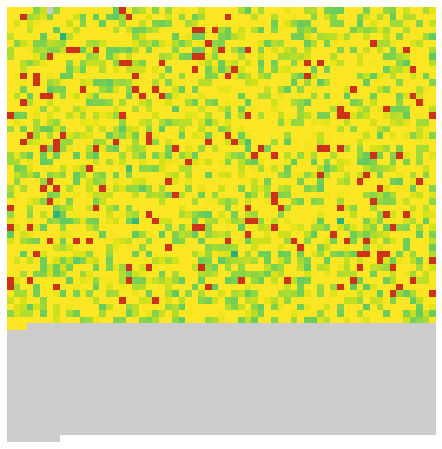

Reward in this step: -2866.706391065278
7
time
8
-------- State at time 8 --------


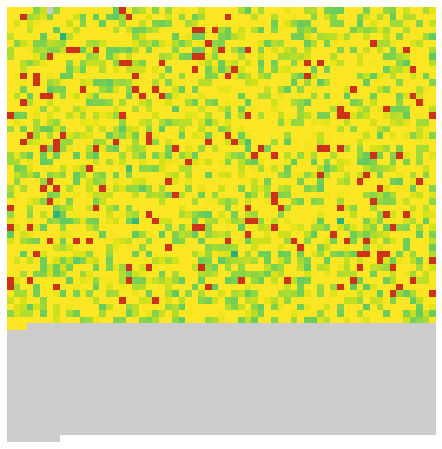

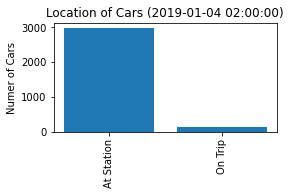

KeyboardInterrupt: 

In [12]:
nr_iterations = 1
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex
env = CarsharingEnv(stations, nr_vehicles = 4233)
if nr_iterations > 577:
    nr_iterations = 577
count = 0

for week_nr in range(0, math.ceil(nr_iterations / 7)):
    sql = "SELECT * FROM msc_2023_dominik.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)

    

    vehicle_list = data.iloc[:,1].tolist()
    nr_vehicles = data.shape[0]
    end_of_week = False
    for day in range(99,676,96):
        date = pd.to_datetime(data.columns[day-97])
        last_timestamp = date + pd.Timedelta(days=1)

        last_timestamp = pd.Timestamp(last_timestamp.date())
       



        sql = "SELECT * FROM msc_2023_dominik.reservations_discrete WHERE reservationfrom_discrete_date = '{}' or reservationfrom_discrete = '{}' ORDER BY reservationfrom_discrete".format(date, last_timestamp)
        reservations = pd.read_sql(sql, engine)

        reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)

        if count == nr_iterations:
            break
        dayly_data = data.iloc[:,day-97:day]
        s = env.reset(dayly_data, vehicle_list)
        done = False
        if day == 675:
            end_of_week = True
        counter = 0
        while not done:
            print(counter)
            # always charge all vehicles
            act = np.ones(nr_vehicles)
            #if counter > 20:
            #    act = np.full(nr_vehicles, 2)
            #act = np.zeros(nr_vehicles)
            s, rew, dayly_data, done, _ = env.step(act, dayly_data, reservations, stations, end_of_week)
            env.render(dayly_data)
            print("Reward in this step:", rew)
            counter +=1
                              
        env.episode_summary_statistics(dayly_data)
        count += 1

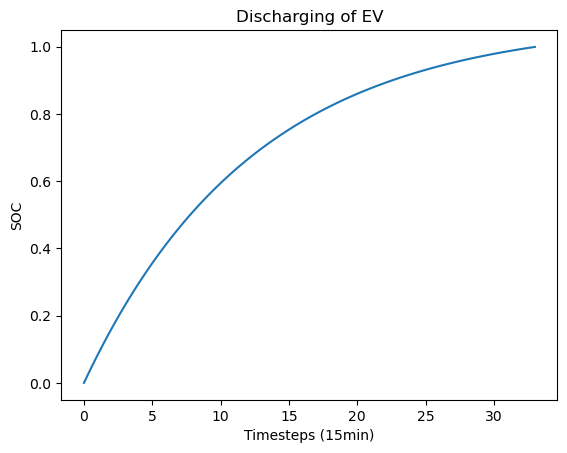

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def f(c, p, t):
    return (1 - np.exp(-t * 0.6 / (c/p))) * 1.075
def reflected_f(c, p, t):
     return (1 - np.exp(t * 0.6 / (c/p))) * 0.07514760980634634
    


c = 82  # kWh
p = 11  # kW
t = np.linspace(0, 33, 100)

f_t = f(c, p, t)
f_t = f(c, p, t)

plt.plot(t, f_t)
plt.xlabel('Timesteps (15min)')
plt.ylabel('SOC')
plt.title('Discharging of EV')
plt.show()